In [1]:
# Parameters
setor = "Com\xe9rcio"


Para rodar, é necessário:
- Criar pastas com os seguintes nomes: dados, img e pdfs
- Colocar os dados necessários na pasta 'dados' (caged.csv, caged_nordeste.csv, cagedest_rn_saldo_mensal.csv, porte_mensal_rn_excel.xlsx e cnaes_subclasses.csv)
    - Obs.: rodar 'build_caged.R' para obter esses dados.
- Instalar as bibliotecas que estão comentadas abaixo

In [2]:
# !pip install weasyprint
# !pip install geobr
# !pip install adjustText

In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import weasyprint
from pathlib import Path
import matplotlib.dates as mdates
import geopandas as gpd
from shapely.geometry import box
import geobr
import matplotlib.pyplot as plt
from adjustText import adjust_text
from datetime import datetime
from pathlib import Path

# Dados

In [4]:
data = pd.read_csv("dados/caged.csv")

In [5]:
data.head()

,competênciamov,região,uf,município,seção,subclasse,saldomovimentação,cbo2002ocupação,categoria,graudeinstrução,...,unidadesaláriocódigo,valorsaláriofixo,competênciaexc,indicadordeexclusão,admitidos,desligados,NI,grande_grupamento,porte,data
0,202001,2,24,240810,G,4511102,-1,521110,101,6,...,5,103900.0,NaN,NaN,0,-1,NaN,Comércio,Micro,2020-01-01
1,202001,2,24,240810,Q,8630502,1,514320,101,7,...,5,106078.0,NaN,NaN,1,0,NaN,Serviços,Média,2020-01-01
2,202001,2,24,240810,N,8111700,-1,517410,101,3,...,5,96500.0,NaN,NaN,0,-1,NaN,Serviços,Grande,2020-01-01
3,202001,2,24,241420,I,5510801,-1,422105,999,7,...,99,NaN,NaN,NaN,0,-1,NaN,Serviços,Micro,2020-01-01
4,202001,2,24,240800,N,8299799,1,524105,101,7,...,5,103900.0,NaN,NaN,1,0,NaN,Serviços,Pequena,2020-01-01


In [6]:
subclasses = pd.read_csv("dados/cnaes_subclasses.csv",encoding='latin1', sep=';')

In [7]:
subclasses['num_cnae'] = subclasses['num_cnae'].fillna(0).astype(int)

In [8]:
subclasses.head()

,CNAE.CNAE_SUBCLASSE,num_cnae,desc_cnae
0,"7722500 - Aluguel de fitas de vídeo, DVDs e si...",7722500,"Aluguel de fitas de vídeo, DVDs e similares"
1,8630503 - Atividade médica ambulatorial restri...,8630503,Atividade médica ambulatorial restrita a consu...
2,133402 - Cultivo de banana,133402,Cultivo de banana
3,1321900 - Tecelagem de fios de algodão,1321900,Tecelagem de fios de algodão
4,8413200 - Regulação das atividades econômicas,8413200,Regulação das atividades econômicas


In [9]:
# Realizar o merge com base na correspondência entre 'num_cnae' e 'subclasse'
data = data.merge(subclasses[['num_cnae', 'desc_cnae']], 
                  how='left', 
                  left_on='subclasse', 
                  right_on='num_cnae')

In [10]:
data.head()

,competênciamov,região,uf,município,seção,subclasse,saldomovimentação,cbo2002ocupação,categoria,graudeinstrução,...,competênciaexc,indicadordeexclusão,admitidos,desligados,NI,grande_grupamento,porte,data,num_cnae,desc_cnae
0,202001,2,24,240810,G,4511102,-1,521110,101,6,...,NaN,NaN,0,-1,NaN,Comércio,Micro,2020-01-01,4511102.0,"Comércio a varejo de automóveis, camionetas e ..."
1,202001,2,24,240810,Q,8630502,1,514320,101,7,...,NaN,NaN,1,0,NaN,Serviços,Média,2020-01-01,8630502.0,Atividade médica ambulatorial com recursos par...
2,202001,2,24,240810,N,8111700,-1,517410,101,3,...,NaN,NaN,0,-1,NaN,Serviços,Grande,2020-01-01,8111700.0,"Serviços combinados para apoio a edifícios, ex..."
3,202001,2,24,241420,I,5510801,-1,422105,999,7,...,NaN,NaN,0,-1,NaN,Serviços,Micro,2020-01-01,5510801.0,Hotéis
4,202001,2,24,240800,N,8299799,1,524105,101,7,...,NaN,NaN,1,0,NaN,Serviços,Pequena,2020-01-01,8299799.0,Outras atividades de serviços prestados princi...


In [11]:
data.shape

(2107015, 38)

In [12]:
data['ano'] = data['competênciamov'].astype(str).str[:4]

In [13]:
data['data'] = pd.to_datetime(data['data'])
# Encontrar a data mais recente
data_mais_recente = data['data'].max()

# Converter para o formato 'YYYYMM' como string
competencia = data_mais_recente.strftime('%Y%m')

# Exibir a competência
print("Competência:", competencia)

Competência: 202505


In [14]:
import locale

# Configurar o locale para o idioma português do Brasil
locale.setlocale(locale.LC_TIME, 'pt_BR.UTF-8')

# Converter a data mais recente para um texto por extenso
mes_referente = data_mais_recente.strftime('%B de %Y').capitalize()

# Exibir a data por extenso
print("Data por extenso:", mes_referente)


Data por extenso: Maio de 2025


In [15]:
meses_pt = {
    1: 'janeiro', 2: 'fevereiro', 3: 'março',
    4: 'abril', 5: 'maio', 6: 'junho',
    7: 'julho', 8: 'agosto', 9: 'setembro',
    10: 'outubro', 11: 'novembro', 12: 'dezembro'
}

data_mais_recente = pd.to_datetime(data['data']).max()
mes_referente = f"{meses_pt[data_mais_recente.month]} de {data_mais_recente.year}"
mes_referente = mes_referente.capitalize()


In [16]:
print("Data por extenso:", mes_referente)

Data por extenso: Maio de 2025


In [17]:
mes_nome = mes_referente.split()[0]
ano = mes_referente.split()[-1]

In [18]:
data.columns

Index(['competênciamov', 'região', 'uf', 'município', 'seção', 'subclasse',
       'saldomovimentação', 'cbo2002ocupação', 'categoria', 'graudeinstrução',
       'idade', 'horascontratuais', 'raçacor', 'sexo', 'tipoempregador',
       'tipoestabelecimento', 'tipomovimentação', 'tipodedeficiência',
       'indtrabintermitente', 'indtrabparcial', 'salário', 'tamestabjan',
       'indicadoraprendiz', 'origemdainformação', 'competênciadec',
       'indicadordeforadoprazo', 'unidadesaláriocódigo', 'valorsaláriofixo',
       'competênciaexc', 'indicadordeexclusão', 'admitidos', 'desligados',
       'NI', 'grande_grupamento', 'porte', 'data', 'num_cnae', 'desc_cnae',
       'ano'],
      dtype='object')

In [19]:
data['competênciamov'] = data['competênciamov'].astype(str)

admissoes = data.loc[(data['saldomovimentação'] == 1) & (data['competênciamov'] == competencia)]
total_admissoes = admissoes['saldomovimentação'].sum()

desligamentos = data.loc[(data['saldomovimentação'] == -1) & (data['competênciamov'] == competencia)]
total_desligamentos = -desligamentos['saldomovimentação'].sum()

saldo = data.loc[(data['competênciamov'] == competencia)]['saldomovimentação'].sum()

In [20]:
data['data'] = pd.to_datetime(data['data'])

In [21]:
data.head()

,competênciamov,região,uf,município,seção,subclasse,saldomovimentação,cbo2002ocupação,categoria,graudeinstrução,...,indicadordeexclusão,admitidos,desligados,NI,grande_grupamento,porte,data,num_cnae,desc_cnae,ano
0,202001,2,24,240810,G,4511102,-1,521110,101,6,...,NaN,0,-1,NaN,Comércio,Micro,2020-01-01,4511102.0,"Comércio a varejo de automóveis, camionetas e ...",2020
1,202001,2,24,240810,Q,8630502,1,514320,101,7,...,NaN,1,0,NaN,Serviços,Média,2020-01-01,8630502.0,Atividade médica ambulatorial com recursos par...,2020
2,202001,2,24,240810,N,8111700,-1,517410,101,3,...,NaN,0,-1,NaN,Serviços,Grande,2020-01-01,8111700.0,"Serviços combinados para apoio a edifícios, ex...",2020
3,202001,2,24,241420,I,5510801,-1,422105,999,7,...,NaN,0,-1,NaN,Serviços,Micro,2020-01-01,5510801.0,Hotéis,2020
4,202001,2,24,240800,N,8299799,1,524105,101,7,...,NaN,1,0,NaN,Serviços,Pequena,2020-01-01,8299799.0,Outras atividades de serviços prestados princi...,2020


In [22]:
cagedest_rn_saldo_mensal =  pd.read_csv("dados/cagedest_rn_saldo_mensal.csv")
print(cagedest_rn_saldo_mensal)

           data  Saldo
0    2007-01-01    351
1    2007-02-01  -1394
2    2007-03-01  -1076
3    2007-04-01   1615
4    2007-05-01   1355
..          ...    ...
151  2019-08-01   3951
152  2019-09-01   2513
153  2019-10-01   3025
154  2019-11-01   1597
155  2019-12-01  -3133

[156 rows x 2 columns]


In [23]:
porte_mensal_rn_excel =  pd.read_excel("dados/porte_mensal_rn_excel.xlsx")
print(porte_mensal_rn_excel)

          data    porte  Saldo
0   2020-01-01   Grande  -1692
1   2020-01-01    Micro   1685
2   2020-01-01    Média   -870
3   2020-01-01  Pequena   -197
4   2020-02-01   Grande  -3293
..         ...      ...    ...
255 2025-04-01  Pequena    -58
256 2025-05-01   Grande    -92
257 2025-05-01    Micro   1814
258 2025-05-01    Média    232
259 2025-05-01  Pequena    266

[260 rows x 3 columns]


In [24]:
caged_nordeste =  pd.read_csv("dados/caged_nordeste.csv")
print(caged_nordeste)

   uf  Saldo               Estado
0  21   3560             Maranhão
1  22   3559                Piauí
2  23   5769                Ceará
3  24   2220  Rio Grande do Norte
4  25   5905              Paraíba
5  26   9754           Pernambuco
6  27    324              Alagoas
7  28   1939              Sergipe
8  29  12858                Bahia


In [25]:
# Estoque de referência em dezembro de 2023
estoque_referencia_dez_2023 = 501921

# Filtrar e calcular o saldo a partir de 2024-01-01
saldo_total = porte_mensal_rn_excel[porte_mensal_rn_excel['data'] >= "2024-01-01"]['Saldo'].sum()

# Calcular o estoque final
estoque = estoque_referencia_dez_2023 + saldo_total

# Exibir o resultado
print("Estoque:", estoque)

Estoque: 541429


In [26]:
# Ajustando formato dos números
total_admissoes = f"{total_admissoes:,}".replace(",", ".")
saldo = f"{saldo:,}".replace(",", ".")
total_desligamentos = f"{total_desligamentos:,}".replace(",", ".")
estoque = f"{estoque:,}".replace(",", ".")

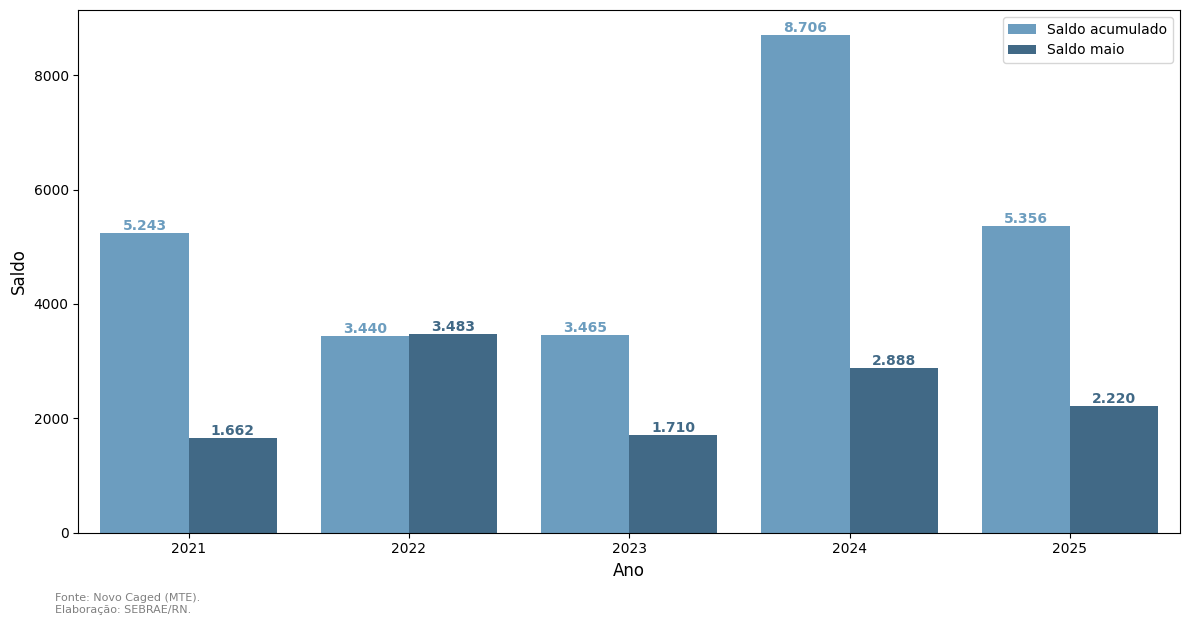

Gráfico salvo em: img/grafico_acumulado_ano_e_mes.png


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

def criar_grafico_acumulado_ano_e_mes_mais_recente(data):
    # Garantir que a coluna 'data' esteja no formato datetime
    data['data'] = pd.to_datetime(data['data'], errors='coerce')

    # Criar uma nova coluna 'ano' e 'mes' para agrupamento
    data['ano'] = data['data'].dt.year
    data['mes'] = data['data'].dt.month

    # Identificar o mês mais recente da base
    mes_mais_recente = data['data'].max().month
    nome_mes_mais_recente = calendar.month_name[mes_mais_recente]  # Nome do mês (ex: Novembro)

    # Filtrar os últimos 4 anos
    ano_atual = data['ano'].max()
    anos_filtrados = list(range(ano_atual - 4, ano_atual + 1))  # Últimos 4 anos
    data_filtrada = data[data['ano'].isin(anos_filtrados)]

    # Calcular o saldo acumulado do ano até o mês mais recente
    saldo_acumulado = data_filtrada[data_filtrada['mes'] <= mes_mais_recente].groupby('ano')['saldomovimentação'].sum().reset_index()
    saldo_acumulado.rename(columns={'saldomovimentação': 'Saldo acumulado'}, inplace=True)


    # Calcular o saldo do mês mais recente
    saldo_mes = data_filtrada[data_filtrada['mes'] == mes_mais_recente].groupby('ano')['saldomovimentação'].sum().reset_index()
    saldo_mes.rename(columns={'saldomovimentação': f'Saldo {nome_mes_mais_recente}'}, inplace=True)

    # Unir os dois conjuntos de dados
    merged_data = pd.merge(saldo_acumulado, saldo_mes, on='ano', how='outer').fillna(0)

    # Transformar os dados para formato longo (long format) para o gráfico
    melted_data = pd.melt(merged_data, id_vars='ano', value_vars=['Saldo acumulado', f'Saldo {nome_mes_mais_recente}'],
                          var_name='Tipo', value_name='Saldo')

    # Criar o gráfico de barras
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='ano', y='Saldo', hue='Tipo', data=melted_data, palette='Blues_d')

    # Remover o título da legenda
    ax.legend(title=None)

    # Títulos e rótulos
    plt.xlabel("Ano", fontsize=12)
    plt.ylabel("Saldo", fontsize=12)

    # Adicionar valores no topo de cada barra com a cor da barra
    for p in ax.patches:
        height = p.get_height()
        color = p.get_facecolor()  # Obtém a cor da barra
        if height != 0:  # Evitar exibir "0"
            ax.text(
                p.get_x() + p.get_width() / 2.,  # Posição horizontal
                height,  # Posição vertical (no topo da barra)
                '{:,.0f}'.format(height).replace(',', '.'),  # Formatação do número
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, fontweight='bold',
                color=color  # Define a cor do texto igual à cor da barra
            )

    # Adicionar informações de fonte e elaboração
    plt.figtext(0.05, -0.01, 'Fonte: Novo Caged (MTE).',
                ha='left', fontsize=8, color='gray', weight='normal')
    plt.figtext(0.05, -0.03, 'Elaboração: SEBRAE/RN.',
                ha='left', fontsize=8, color='gray', weight='normal')

    # Ajustar layout
    plt.tight_layout()

    # Salvar o gráfico
    grafico_path = f'img/grafico_acumulado_ano_e_mes.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)
    plt.show()

    return grafico_path

# Exemplo de chamada da função
# Suponha que `data` seja um DataFrame previamente carregado
grafico_path = criar_grafico_acumulado_ano_e_mes_mais_recente(data)
print(f"Gráfico salvo em: {grafico_path}")


In [28]:
data['data'] = pd.to_datetime(data['data'], errors='coerce')

data['ano'] = data['data'].dt.year
data['mes'] = data['data'].dt.month

    # Identificar o mês mais recente da base
mes_mais_recente = data['data'].max().month
nome_mes_mais_recente = calendar.month_name[mes_mais_recente]  # Nome do mês (ex: Novembro)

    # Filtrar os últimos 4 anos
ano_atual = data['ano'].max()
anos_filtrados = list(range(ano_atual - 4, ano_atual + 1))  # Últimos 4 anos
data_filtrada = data[data['ano'].isin(anos_filtrados)]

    # Calcular o saldo acumulado do ano
saldo_acumulado = data_filtrada.groupby('ano')['saldomovimentação'].sum().reset_index()
saldo_acumulado.rename(columns={'saldomovimentação': 'Saldo acumulado'}, inplace=True)

In [29]:
# Agrupar os dados por ano e mês
saldo_por_mes = data_filtrada.groupby(['ano', 'mes'])['saldomovimentação'].sum().reset_index()

# Adicionar o nome do mês para facilitar a leitura
saldo_por_mes['nome_mes'] = saldo_por_mes['mes'].apply(lambda x: calendar.month_name[x])

# Ordenar os dados por ano e mês
saldo_por_mes = saldo_por_mes.sort_values(by=['ano', 'mes']).reset_index(drop=True)

# Exibir o resultado
print(saldo_por_mes)


     ano  mes  saldomovimentação   nome_mes
0   2021    1               1845    janeiro
1   2021    2               1568  fevereiro
2   2021    3               1213     marÃ§o
3   2021    4              -1045      abril
4   2021    5               1662       maio
5   2021    6               4622      junho
6   2021    7               3903      julho
7   2021    8               7440     agosto
8   2021    9               6366   setembro
9   2021   10               3474    outubro
10  2021   11               3162   novembro
11  2021   12              -1530   dezembro
12  2022    1              -2598    janeiro
13  2022    2               2146  fevereiro
14  2022    3              -1429     marÃ§o
15  2022    4               1838      abril
16  2022    5               3483       maio
17  2022    6               3872      junho
18  2022    7               2760      julho
19  2022    8               6847     agosto
20  2022    9               4225   setembro
21  2022   10               1851

In [30]:
soma_2024 = saldo_por_mes[saldo_por_mes['ano'] == 2024]['saldomovimentação'].sum()

# Exibir o resultado
print(f"Soma total do saldo de 2024: {soma_2024}")

Soma total do saldo de 2024: 34152


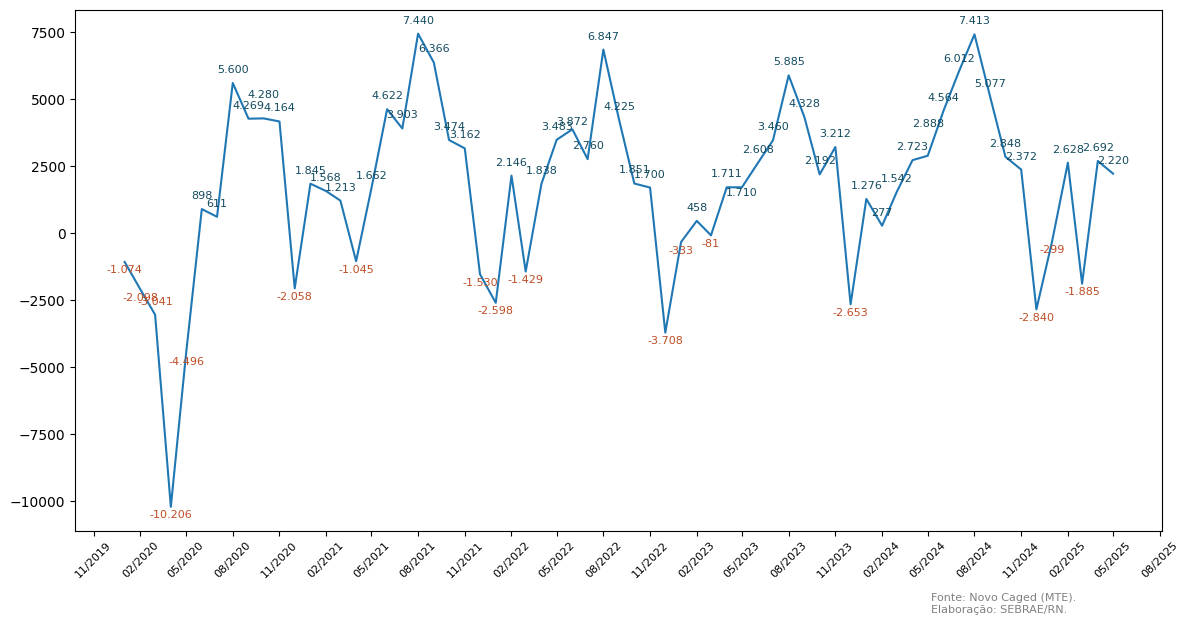

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

def criar_grafico_ts(data):
    # Certifique-se de que a coluna 'data' é do tipo datetime
    if not pd.api.types.is_datetime64_any_dtype(data['data']):
        data['data'] = pd.to_datetime(data['data'])

    # Agrupamento dos dados
    grouped_data = data.groupby('data')['saldomovimentação'].sum().reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='data', y='saldomovimentação', data=grouped_data)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("")

    # Configurações do eixo X para datas
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Exibe de 3 em 3 meses
    plt.xticks(rotation=45, fontsize=8)  # Diminui o tamanho da fonte para 8

    # Ajuste de espaçamento do gráfico
    plt.tight_layout()

    # Adicionar valores nos pontos
    last_y = None
    for x, y in zip(grouped_data['data'], grouped_data['saldomovimentação']):
        color = '#134b5f' if y >= 0 else '#be4d25'
        offset = 300 if y >= 0 else -500

        # Ajuste dinâmico para evitar sobreposição
        if last_y is not None and abs(y - last_y) < 500:
            offset = -300 if y > last_y else 300

        # Levantar o número específico do mês 10/2020
        if x.strftime('%m/%Y') == '10/2020':
            offset += 400  # Aumenta o deslocamento vertical

        if x.strftime('%m/%Y') == '06/2022':
            offset += 400  # Aumenta o deslocamento vertical

        if x.strftime('%m/%Y') == '05/2023':
            offset += -700  # Aumenta o deslocamento vertical

        if x.strftime('%m/%Y') == '05/2024':
            offset += 700  # Aumenta o deslocamento vertical

        plt.text(x, y + offset, '{:,.0f}'.format(y).replace(',', '.'),
                 ha='center', va='bottom', fontsize=8, color=color)
        last_y = y + offset

    # Notas no rodapé
    plt.figtext(0.78, -0.01, 'Fonte: Novo Caged (MTE).',
                ha='left', fontsize=8, color='gray', weight='normal')
    plt.figtext(0.78, -0.03, 'Elaboração: SEBRAE/RN.',
                ha='left', fontsize=8, color='gray', weight='normal')

    # Salvar gráfico
    grafico_path = 'img/grafico_saldo_ts.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)
    plt.show()

    return grafico_path

# Uso da função
grafico_ts = criar_grafico_ts(data)


In [32]:
# Filtra pela competência desejada
filtro = data[data['ano'] == int(ano)]

# Agrupa por setor e cnae, somando os saldos
grupo_saldos = filtro.groupby(['grande_grupamento', 'desc_cnae'])['saldomovimentação'].sum().reset_index()

# Para cada setor, pega o cnae com maior saldo
top_cnaes_df = grupo_saldos.sort_values('saldomovimentação', ascending=False) \
                           .groupby('grande_grupamento') \
                           .first() \
                           .reset_index()

top_cnaes_df = top_cnaes_df.rename(columns={
    'grande_grupamento': 'Setor',
    'desc_cnae': 'CNAE',
    'saldomovimentação': 'Saldo de Movimentação'
})

In [33]:
top_cnaes_df

,Setor,CNAE,Saldo de Movimentação
0,Agropecuária,Produção de ovos,59
1,Comércio,"Comércio varejista de mercadorias em geral, co...",180
2,Construção,Construção de edifícios,1571
3,Indústria,"Atividades relacionadas a esgoto, exceto a ges...",2600
4,Serviços,Atividades de monitoramento de sistemas de seg...,1087


In [34]:
# Filtra pela competência desejada
filtro = data[data['ano'] == int(ano)]

# Agrupa por setor e CNAE, somando os saldos
grupo_saldos = filtro.groupby(['grande_grupamento', 'desc_cnae'])['saldomovimentação'].sum().reset_index()

# Para cada setor, pega o CNAE com MENOR saldo
bottom_cnaes_df = grupo_saldos.sort_values('saldomovimentação', ascending=True) \
                              .groupby('grande_grupamento') \
                              .first() \
                              .reset_index()

# Renomeia as colunas para manter o padrão
bottom_cnaes_df = bottom_cnaes_df.rename(columns={
    'grande_grupamento': 'Setor',
    'desc_cnae': 'CNAE',
    'saldomovimentação': 'Saldo de Movimentação'
})


In [35]:
bottom_cnaes_df

,Setor,CNAE,Saldo de Movimentação
0,Agropecuária,Cultivo de melão,-3125
1,Comércio,Comércio varejista de artigos do vestuário e a...,-472
2,Construção,Obras de montagem industrial,-267
3,Indústria,Fabricação de álcool,-745
4,Serviços,Seleção e agenciamento de mão de obra,-3248


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def criar_grafico_saldo_setor(data, competencia, top_cnaes_df, bottom_cnaes_df):
    # Extrair o ano da competência
    ano = int(str(competencia)[:4])
    data_mes = data[data['ano'] == ano]

    # Agrupar os dados por setor
    grouped_data = data_mes.groupby('grande_grupamento')['saldomovimentação'].sum().reset_index()

    # Obter CNAEs por setor de acordo com o saldo
    def obter_desc_cnae(grupo, saldo):
        if saldo > 0:
            df = top_cnaes_df[top_cnaes_df['Setor'] == grupo]
            if not df.empty:
                cnae = df.iloc[0]
                texto = f"↑ {cnae['CNAE']}: {int(cnae['Saldo de Movimentação'])}"
                return quebra_linha(texto), '#154c79'
        elif saldo < 0:
            df = bottom_cnaes_df[bottom_cnaes_df['Setor'] == grupo]
            if not df.empty:
                cnae = df.iloc[0]
                texto = f"↓ {cnae['CNAE']}: {int(cnae['Saldo de Movimentação'])}"
                return quebra_linha(texto), 'red'
        return "", 'black'

    # Quebra de linha automática
    def quebra_linha(texto):
        return '\n'.join([texto[i:i+31] for i in range(0, len(texto), 31)]) if len(texto) > 31 else texto

    # Criar colunas com os CNAEs e cores
    textos_cnae = []
    cores_cnae = []

    for _, row in grouped_data.iterrows():
        texto, cor = obter_desc_cnae(row['grande_grupamento'], row['saldomovimentação'])
        textos_cnae.append(texto)
        cores_cnae.append(cor)

    grouped_data['desc_cnae'] = textos_cnae
    grouped_data['cor_cnae'] = cores_cnae

    # Ordenar setores pelo saldo
    grouped_data = grouped_data.sort_values(by='saldomovimentação', ascending=False)

    # Ajustar altura com base no número de setores
    num_setores = len(grouped_data)
    altura_figura = max(6, num_setores * 1.2)
    plt.figure(figsize=(12, altura_figura))

    # Criar gráfico
    ax = sns.barplot(x='grande_grupamento', y='saldomovimentação', data=grouped_data, palette='Blues_d')
    plt.ylabel("")
    plt.xlabel("")
    plt.axhline(0, color='black', linewidth=1)

    # Limites do eixo Y para base de texto
    ylim_min, ylim_max = ax.get_ylim()
    deslocamento = (ylim_max - ylim_min) * 0.05  # 5% do intervalo

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        cnae_text = grouped_data.iloc[i]['desc_cnae']
        cnae_color = grouped_data.iloc[i]['cor_cnae']

        # Valor no topo da barra
        if height > 0:
            y_text = height + deslocamento
            va_position = "bottom"
            saldo_color = 'black'
        elif height < 0:
            y_text = height - deslocamento
            va_position = "top"
            saldo_color = 'red'
        else:
            y_text = 0
            va_position = "bottom"
            saldo_color = 'black'

        ax.text(
            p.get_x() + p.get_width() / 2., y_text,
            '{:,.0f}'.format(height).replace(',', '.'),
            ha="center", va=va_position, fontsize=10, fontweight='bold', color=saldo_color
        )

        # Texto CNAE logo abaixo do nome do setor
        if cnae_text:
            y_tick_base = ylim_min - deslocamento
            ax.text(
                p.get_x() + p.get_width() / 2., y_tick_base,
                cnae_text,
                ha="center", va="top", fontsize=8, color=cnae_color
            )

    plt.tight_layout()

    # Rodapé
    plt.figtext(0.03, -0.01, 'Fonte: Novo Caged (MTE).',
                ha='left', fontsize=8, color='gray')
    plt.figtext(0.03, -0.03, 'Elaboração: SEBRAE/RN.',
                ha='left', fontsize=8, color='gray')

    # Salvar gráfico
    grafico_path = 'img/grafico_saldo_setor_acumulado.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)
    plt.close()

    return grafico_path

# Exemplo de uso:
grafico_saldo_setor = criar_grafico_saldo_setor(data, competencia, top_cnaes_df, bottom_cnaes_df)



C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_22708\1748528156.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='grande_grupamento', y='saldomovimentação', data=grouped_data, palette='Blues_d')


In [37]:
def criar_grafico_saldo_setor(data, competencia, top_cnaes_df, bottom_cnaes_df):
    # Filtrar dados da competência
    data_ano = data[data['competênciamov'] == competencia]

    # Agrupar por setor
    grouped_data = data_ano.groupby('grande_grupamento')['saldomovimentação'].sum().reset_index()

    # Obter texto do CNAE por setor
    def obter_desc_cnae(grupo, saldo):
        if saldo > 0:
            df = top_cnaes_df[top_cnaes_df['Setor'] == grupo]
            if not df.empty:
                cnae = df.iloc[0]
                texto = f"↑ {cnae['CNAE']}: {int(cnae['Saldo de Movimentação'])}"
                return quebra_linha(texto), '#154c79'
        elif saldo < 0:
            df = bottom_cnaes_df[bottom_cnaes_df['Setor'] == grupo]
            if not df.empty:
                cnae = df.iloc[0]
                texto = f"↓ {cnae['CNAE']}: {int(cnae['Saldo de Movimentação'])}"
                return quebra_linha(texto), 'red'
        return "", 'black'

    # Quebra linha automática
    def quebra_linha(texto):
        return '\n'.join([texto[i:i+31] for i in range(0, len(texto), 31)]) if len(texto) > 31 else texto

    # Aplicar textos e cores dos CNAEs
    textos_cnae = []
    cores_cnae = []

    for _, row in grouped_data.iterrows():
        texto, cor = obter_desc_cnae(row['grande_grupamento'], row['saldomovimentação'])
        textos_cnae.append(texto)
        cores_cnae.append(cor)

    grouped_data['desc_cnae'] = textos_cnae
    grouped_data['cor_cnae'] = cores_cnae

    # Ordenar os setores
    grouped_data = grouped_data.sort_values(by='saldomovimentação', ascending=False)

    # Ajustar tamanho da figura dinamicamente
    num_setores = len(grouped_data)
    altura_figura = max(6, num_setores * 1.2)
    plt.figure(figsize=(12, altura_figura))

    # Criar gráfico
    ax = sns.barplot(x='grande_grupamento', y='saldomovimentação', data=grouped_data, palette='Blues_d')
    plt.ylabel("")
    plt.xlabel("")
    plt.axhline(0, color='black', linewidth=1)

    # Calcular intervalo do eixo Y
    ylim_min, ylim_max = ax.get_ylim()
    deslocamento = (ylim_max - ylim_min) * 0.05  # 5% para cima/baixo

    for i, p in enumerate(ax.patches):
        height = p.get_height()
        cnae_text = grouped_data.iloc[i]['desc_cnae']
        cnae_color = grouped_data.iloc[i]['cor_cnae']

        # Texto no topo da barra
        if height > 0:
            y_text = height + deslocamento
            va_position = "bottom"
            saldo_color = 'black'
        elif height < 0:
            y_text = height - deslocamento
            va_position = "top"
            saldo_color = 'red'
        else:
            y_text = 0
            va_position = "bottom"
            saldo_color = 'black'

        ax.text(
            p.get_x() + p.get_width() / 2., y_text,
            '{:,.0f}'.format(height).replace(',', '.'),
            ha="center", va=va_position, fontsize=10, fontweight='bold', color=saldo_color
        )

        # Texto do CNAE abaixo do nome do setor
        if cnae_text:
            y_tick_base = ylim_min - deslocamento
            ax.text(
                p.get_x() + p.get_width() / 2., y_tick_base,
                cnae_text,
                ha="center", va="top", fontsize=8, color=cnae_color
            )

    plt.tight_layout()

    # Rodapé
    plt.figtext(0.03, -0.01, 'Fonte: Novo Caged (MTE).',
                ha='left', fontsize=8, color='gray')
    plt.figtext(0.03, -0.03, 'Elaboração: SEBRAE/RN.',
                ha='left', fontsize=8, color='gray')

    # Salvar gráfico
    grafico_path = 'img/grafico_saldo_setor_mensal.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)
    plt.close()

    return grafico_path

# Exemplo de uso:
grafico_saldo_setor = criar_grafico_saldo_setor(data, competencia, top_cnaes_df, bottom_cnaes_df)


C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_22708\4116920174.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='grande_grupamento', y='saldomovimentação', data=grouped_data, palette='Blues_d')


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

def criar_grafico_mes_anos_anteriores(data, cagedest_rn_saldo_mensal):
    # Ajustar a coluna 'data' em ambas as bases para o formato 'YYYY-MM'
    data['data'] = pd.to_datetime(data['data'], errors='coerce')
    cagedest_rn_saldo_mensal['data'] = pd.to_datetime(cagedest_rn_saldo_mensal['data'], errors='coerce')

    # Identificar o mês mais recente da base
    mes_mais_recente = data['data'].max().month
    nome_mes_mais_recente = calendar.month_name[mes_mais_recente]  # Nome do mês (ex: Novembro)

    # Filtrar os dados para o mês mais recente e a partir de 2014
    data = data[(data['data'].dt.month == mes_mais_recente) & (data['data'].dt.year >= 2014)]
    cagedest_rn_saldo_mensal = cagedest_rn_saldo_mensal[
        (cagedest_rn_saldo_mensal['data'].dt.month == mes_mais_recente) &
        (cagedest_rn_saldo_mensal['data'].dt.year >= 2014)
    ]

    # Agrupar os dados de ambas as bases
    data_grouped = data.groupby(data['data'].dt.year)['saldomovimentação'].sum().reset_index()
    cagedest_grouped = cagedest_rn_saldo_mensal.groupby(cagedest_rn_saldo_mensal['data'].dt.year)['Saldo'].sum().reset_index()

    # Renomear colunas para evitar conflitos
    data_grouped.rename(columns={'saldomovimentação': 'Saldo Data', 'data': 'Ano'}, inplace=True)
    cagedest_grouped.rename(columns={'Saldo': 'Saldo Cagedest', 'data': 'Ano'}, inplace=True)

    # Fazer a união dos dois conjuntos de dados (merge)
    merged_data = pd.merge(data_grouped, cagedest_grouped, on='Ano', how='outer').fillna(0)

    # Somar os saldos para um total consolidado
    merged_data['Saldo Total'] = merged_data['Saldo Data'] + merged_data['Saldo Cagedest']

    # Criar o gráfico
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Ano', y='Saldo Total', data=merged_data, color="#1574bc")

    # Títulos e rótulos
    plt.xlabel(f"Ano ({nome_mes_mais_recente})", fontsize=12)
    plt.ylabel("Saldo Total", fontsize=12)

    # Adicionar valores no topo de cada barra (ajustar para números negativos)
    for p in ax.patches:
        height = p.get_height()
        if height >= 0:
            ax.text(
                p.get_x() + p.get_width() / 2.,  # Posição horizontal
                height,  # Posição vertical (no topo da barra)
                '{:,.0f}'.format(height).replace(',', '.'),  # Formatação do número
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='#1574bc'
            )
        else:
            ax.text(
                p.get_x() + p.get_width() / 2.,  # Posição horizontal
                height,  # Posição vertical (acima do valor negativo)
                '{:,.0f}'.format(height).replace(',', '.'),  # Formatação do número
                ha='center', va='top', fontsize=10, fontweight='bold', color='#d62728'
            )
    
    plt.figtext(0.1, -0.01, 'Fonte: Novo Caged (MTE).',
                    ha='left', fontsize=8, color='gray', weight='normal')
    plt.figtext(0.1, -0.03, 'Elaboração: SEBRAE/RN.',
                    ha='left', fontsize=8, color='gray', weight='normal')

    # Salvar o gráfico
    grafico_path = f'img/grafico_mes_colunas.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)
    plt.show()

    return grafico_path

# Exemplo de chamada da função
# Suponha que `data` e `cagedest_rn_saldo_mensal` sejam DataFrames previamente carregados
grafico_path = criar_grafico_mes_anos_anteriores(data, cagedest_rn_saldo_mensal)
print(f"Gráfico salvo em: {grafico_path}")


Gráfico salvo em: img/grafico_mes_colunas.png


C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\2077463590.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [39]:
def criar_grafico_saldo_porte(data):
    data['competênciamov'] = data['competênciamov'].astype(str)
    # Filtrar os dados onde o ano da 'competênciamov' é igual ao ano de 'competencia'
    ano_competencia = str(competencia)[:4]
    data_ano = data[data['competênciamov'].str[:4] == ano_competencia]
    # Agrupar os dados por 'porte' e somar o saldo de movimentação
    grouped_data = data_ano.groupby('porte')['saldomovimentação'].sum().reset_index()

    # Ordenar os dados para exibir os maiores valores primeiro, se necessário
    grouped_data = grouped_data.sort_values(by='saldomovimentação', ascending=False)

    # Criar o gráfico de barras
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='porte', y='saldomovimentação', data=grouped_data, palette='Blues_d')

    # Títulos e rótulos
    # plt.title("Saldo de Movimentação por Setor")
    plt.ylabel("")
    plt.xlabel('')  # Remove o nome do eixo X

    # Adicionar a linha horizontal no valor 0 do eixo Y
    plt.axhline(0, color='black',linewidth=1)

    # Adicionar os valores de cada barra dentro delas com formatação
    for p in ax.patches:
        # Posição de cada barra
        height = p.get_height()
        # Pegar a cor da barra (cor de preenchimento)
        bar_color = p.get_facecolor()
        # Colocar o valor na ponta da barra
        if height >= 0:
            ax.text(p.get_x() + p.get_width() / 2., height,  # Posição para barras positivas
                    '{:,.0f}'.format(height).replace(',', '.'),
                    ha="center", va="bottom", fontsize=10,
                    fontweight='bold', color=bar_color)
        else:
            ax.text(p.get_x() + p.get_width() / 2., height,  # Posição para barras negativas
                    '{:,.0f}'.format(height).replace(',', '.'),
                    ha="center", va="top", fontsize=10,
                    fontweight='bold', color=bar_color)
            
    plt.figtext(0.05, -0.01, 'Fonte: Novo Caged (MTE).',
                    ha='left', fontsize=8, color='gray', weight='normal')
    plt.figtext(0.05, -0.03, 'Elaboração: SEBRAE/RN.',
                    ha='left', fontsize=8, color='gray', weight='normal')

    # Exibir o gráfico
    plt.tight_layout()

    # Salvar gráfico como arquivo PNG
    grafico_path = 'img/grafico_saldo_porte.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)

    return grafico_path

grafico_saldo_porte = criar_grafico_saldo_porte(data)

C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\2461217741.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='porte', y='saldomovimentação', data=grouped_data, palette='Blues_d')


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def criar_grafico_nordeste(data):
    # Ordenar os dados por saldo para exibir os maiores valores primeiro, se necessário
    grouped_data = data.sort_values(by='Saldo', ascending=False)

    # Customizar as cores das barras
    colors = ['#3a4e5c' if nome == 'Rio Grande do Norte' else '#6c9dbf' for nome in grouped_data['Estado']]

    # Criar o gráfico de barras
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Estado', y='Saldo', data=grouped_data, palette=colors)

    # Títulos e rótulos
    plt.ylabel("")  # Remove o nome do eixo Y
    plt.xlabel("")  # Remove o nome do eixo X

    # Adicionar uma linha horizontal no valor 0 do eixo Y
    plt.axhline(0, color='black', linewidth=1)

    # Adicionar os valores de cada barra no gráfico
    for p, color in zip(ax.patches, colors):
        # Obter a altura da barra
        height = p.get_height()
        # Adicionar rótulo na parte superior da barra (ou inferior se for negativo)
        if height >= 0:
            ax.text(p.get_x() + p.get_width() / 2., height,  # Para barras positivas
                    '{:,.0f}'.format(height).replace(',', '.'),
                    ha="center", va="bottom", fontsize=10,
                    fontweight='bold', color=color)
        else:
            ax.text(p.get_x() + p.get_width() / 2., height,  # Para barras negativas
                    '{:,.0f}'.format(height).replace(',', '.'),
                    ha="center", va="top", fontsize=10,
                    fontweight='bold', color=color)
            
    plt.figtext(0.05, -0.01, 'Fonte: Novo Caged (MTE).',
                    ha='left', fontsize=8, color='gray', weight='normal')
    plt.figtext(0.05, -0.03, 'Elaboração: SEBRAE/RN.',
                    ha='left', fontsize=8, color='gray', weight='normal')

    # Ajustar layout
    plt.tight_layout()

    # Salvar o gráfico como arquivo PNG
    grafico_path = 'img/grafico_nordeste.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)

    return grafico_path

# Exemplo de chamada da função
grafico_nordeste = criar_grafico_nordeste(caged_nordeste)
print(f"Gráfico salvo em: {grafico_nordeste}")


C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\1270981976.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Estado', y='Saldo', data=grouped_data, palette=colors)


Gráfico salvo em: img/grafico_nordeste.png


In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

def criar_grafico_ts_porte(data):
    # Converter a coluna 'competênciamov' para string, caso não seja
    data['competênciamov'] = data['competênciamov'].astype(str)

    # Filtrar os dados onde o ano da 'competênciamov' é igual ao ano de 'competencia'
    ano_competencia = str(competencia)[:4]
    data_ano = data[data['competênciamov'].str[:4] == ano_competencia]

    # Garantir que a coluna 'data' seja do tipo datetime
    data_ano['data'] = pd.to_datetime(data_ano['data'])

    # Agrupar os dados por 'data' e 'porte', somando os valores de 'saldomovimentação'
    grouped_data = data_ano.groupby(['data', 'porte'])['saldomovimentação'].sum().reset_index()

    # Obter a lista de valores únicos de 'porte' e associar cores
    unique_porte = grouped_data['porte'].unique()
    palette = sns.color_palette("muted", n_colors=len(unique_porte))
    color_mapping = dict(zip(unique_porte, palette))

    # Criar o gráfico com hue para a coluna 'porte'
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(x='data', y='saldomovimentação', hue='porte', data=grouped_data, 
                      marker="o", palette=color_mapping)

    # Títulos e rótulos (ajustáveis conforme necessidade)
    plt.title("")
    plt.xlabel("")
    plt.ylabel("")

    # Adicionar a linha cinza no eixo Y = 0
    plt.axhline(0, color='lightgray', linestyle='--', linewidth=1)
    
    # Formatar os rótulos do eixo X para exibir apenas mês/ano
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe de 1 em 1 mês
    plt.xticks(rotation=45)

    # Configurar os ticks do eixo X para garantir que todos os pontos sejam exibidos
    unique_dates = grouped_data['data'].unique()
    plt.xticks(ticks=unique_dates, labels=[date.strftime('%m/%Y') for date in unique_dates])

    # Adicionar valores exatamente no centro dos pontos, com background colorido e números brancos
    for porte in grouped_data['porte'].unique():
        porte_data = grouped_data[grouped_data['porte'] == porte]
        for x, y in zip(porte_data['data'], porte_data['saldomovimentação']):
            # Adicionar texto com um fundo colorido (mesma cor da linha) e texto branco
            plt.text(
                x, y, f'{int(y):,}'.replace(',', '.'),  # Formatação do número
                ha='center', va='center', fontsize=8, color='white',  # Cor do número
                bbox=dict(facecolor=color_mapping[porte], edgecolor='none', boxstyle='round,pad=0.2')  # Fundo colorido
            )

    # Legenda dentro do gráfico no canto superior esquerdo
    plt.legend(
        title="Porte", loc="upper left", frameon=True, fontsize=8,
        title_fontsize=10, facecolor='white', edgecolor='black', fancybox=True
    )

    # Notas no rodapé
    plt.figtext(0.08, -0.01, 'Fonte: Novo Caged (MTE).',
                ha='left', fontsize=8, color='gray', weight='normal')
    plt.figtext(0.08, -0.03, 'Elaboração: SEBRAE/RN.',
                ha='left', fontsize=8, color='gray', weight='normal')

    # Salvar gráfico
    grafico_path = 'img/grafico_ts_porte.png'
    plt.savefig(grafico_path, format='png', bbox_inches='tight', transparent=True)
    plt.show()
    return grafico_path

# Uso da função
grafico_ts_porte = criar_grafico_ts_porte(data)


C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\1549733154.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ano['data'] = pd.to_datetime(data_ano['data'])


C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\1549733154.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Mapa

In [42]:
data['data'] = pd.to_datetime(data['data'], errors='coerce')

caged_mes_atual = data[data['data'] == data['data'].max()]

municipios = (caged_mes_atual.groupby("município", as_index=False)
    .agg(Saldo=("saldomovimentação", "sum")))

# Add ranking columns
municipios["top5"] = municipios["Saldo"].rank(method="min", ascending=False).isin(range(1, 6))
municipios["bottom5"] = municipios["Saldo"].rank(method="min").isin(range(1, 6))
municipios = municipios.rename(columns={"município": "code_muni"})

# Load municipality map
rn_map = geobr.read_municipality(code_muni="RN")
rn_map['code_muni'] = rn_map['code_muni'].astype(str)
rn_map["code_muni"] = rn_map["code_muni"].str[:-3]

# Ensure both are strings
rn_map['code_muni'] = rn_map['code_muni'].astype(str)
municipios['code_muni'] = municipios['code_muni'].astype(str)

# Now merge
map_saldo = pd.merge(rn_map, municipios, on='code_muni', how = 'outer')

# Formatar os números da coluna 'valores' como inteiros no formato brasileiro
map_saldo['Saldo'] = map_saldo['Saldo'].fillna(0).apply(lambda x: f"{int(x):,}".replace(",", "."))

# Create MUN_SALDO column
map_saldo["MUN_SALDO"] = map_saldo.apply(lambda x: f"{x['name_muni']}\n{x['Saldo']}" if x["top5"] or x["bottom5"] else None, axis=1)

# Defining fill and border colors
fill_palette = ["#3CBC3C", "#C64646", "#d3d3d3"]
border_palette = ["#005800", "#C30000", "#939393"]

map_saldo['fill_colors'] = map_saldo.apply(
    lambda x: fill_palette[0] if x['top5'] else (fill_palette[1] if x['bottom5'] else fill_palette[2]), axis=1
)

map_saldo['border_colors'] = map_saldo.apply(
    lambda x: border_palette[0] if x['top5'] else (border_palette[1] if x['bottom5'] else border_palette[2]), axis=1
)

map_saldo_sf = gpd.GeoDataFrame(map_saldo)

# Filtering top5 and bottom5
top5 = map_saldo_sf[map_saldo_sf['top5'].fillna(False)]
bottom5 = map_saldo_sf[map_saldo_sf['bottom5'].fillna(False)]

# Filtering spatially using bounding boxes
def filter_sf(data, xmin=None, xmax=None, ymin=None, ymax=None):
    bbox = box(xmin, ymin, xmax, ymax) if all([xmin, xmax, ymin, ymax]) else None
    if bbox:
        return data[data.intersects(bbox)]
    return data

# Filtering data to the right of xmin
direita = filter_sf(map_saldo_sf, xmin=-36.6)
esquerda = map_saldo_sf[~map_saldo_sf['code_muni'].isin(direita['code_muni'])]

# Adding text colors
direita['text_colors'] = direita.apply(
    lambda x: "#07ca8d" if x['top5'] else ("#C30000" if x['bottom5'] else None), axis=1
)
esquerda['text_colors'] = esquerda.apply(
    lambda x: "#07ca8d" if x['top5'] else ("#C30000" if x['bottom5'] else None), axis=1
)

# Reproject the GeoDataFrames to a projected CRS (e.g., EPSG:3857)
map_saldo_sf = map_saldo_sf.to_crs(epsg=3857)
top5 = top5.to_crs(epsg=3857)
bottom5 = bottom5.to_crs(epsg=3857)


# Calculate the center longitude of the map
x_center = map_saldo_sf.geometry.centroid.x.mean()

# Add centroid y-coordinates for sorting
top5["centroid_y"] = top5.geometry.centroid.y
bottom5["centroid_y"] = bottom5.geometry.centroid.y

# Split top5 and bottom5 into left (esquerda) and right (direita) based on longitude
top5_direita = top5[top5.geometry.centroid.x > x_center].sort_values(by="centroid_y", ascending=False)
top5_esquerda = top5[top5.geometry.centroid.x <= x_center].sort_values(by="centroid_y", ascending=False)
bottom5_direita = bottom5[bottom5.geometry.centroid.x > x_center].sort_values(by="centroid_y", ascending=False)
bottom5_esquerda = bottom5[bottom5.geometry.centroid.x <= x_center].sort_values(by="centroid_y", ascending=False)

# Colors for top5 and bottom5
fill_colors = {"bottom5": "#C64646", "top5": "#3CBC3C"}
border_colors = {"top5": "#005800", "bottom5": "#C30000"}
darker_colors = {"top5": "#004000", "bottom5": "#8B0000"}  # Darker shades for lines

# Track used positions (lines and boxes) to avoid overlaps
used_positions_right = []
used_positions_left = []

def find_non_overlapping_position(base_y, used_positions, step=16000):
    """
    Find a non-overlapping position for text placement.
    """
    y = base_y
    for _ in range(1000):  # Max attempts
        if all(abs(y - used_y) > step for used_y in used_positions):
            used_positions.append(y)
            return y
        y -= step  # Move downward if necessary to avoid overlaps
    return y  # Fallback

# Plot the map
fig, ax = plt.subplots(figsize=(12, 6))
map_saldo_sf.plot(ax=ax, color="#d3d3d3", edgecolor="#939393", label="Other Municipalities")

# Highlight top5 and bottom5 municipalities
top5.plot(ax=ax, color=fill_colors["top5"], edgecolor=border_colors["top5"], label="Top 5")
bottom5.plot(ax=ax, color=fill_colors["bottom5"], edgecolor=border_colors["bottom5"], label="Bottom 5")

# Function to annotate cities
def annotate_cities(df, side, line_color, box_color, x_offset):
    """
    Annotate cities with labels and connecting lines.
    """
    # Subir mais os textos iniciais ajustando base_y
    base_y = df["centroid_y"].max() + 20000  # Ajuste para mover os números mais para cima
    used_positions = used_positions_right if side == "right" else used_positions_left

    for _, row in df.iterrows():
        centroid = row.geometry.centroid
        y = find_non_overlapping_position(base_y, used_positions, step=14000)  # Menor step para compactar mais os textos
        base_y = y  # Move downward para o próximo rótulo

        # Ajustar a posição do texto com base no lado (direita ou esquerda)
        text_x = x_center + x_offset if side == "right" else x_center - x_offset

        # Desenhar uma linha conectando o centróide ao texto
        ax.plot([centroid.x, text_x], [centroid.y, y], "-", color=line_color, lw=0.8)

        # Adicionar o texto ao lado do mapa
        ax.text(
            text_x, y, row["MUN_SALDO"],
            fontsize=8, ha="left" if side == "right" else "right",
            weight="bold",
            bbox=dict(facecolor="white", edgecolor=box_color, boxstyle="round,pad=0.3")
        )

# Annotate cities on the right (direita)
annotate_cities(top5_direita, side="right", line_color=darker_colors["top5"], box_color=border_colors["top5"], x_offset=200000)
annotate_cities(bottom5_direita, side="right", line_color=darker_colors["bottom5"], box_color=border_colors["bottom5"], x_offset=200000)

# Annotate cities on the left (esquerda)
annotate_cities(top5_esquerda, side="left", line_color=darker_colors["top5"], box_color=border_colors["top5"], x_offset=225000)
annotate_cities(bottom5_esquerda, side="left", line_color=darker_colors["bottom5"], box_color=border_colors["bottom5"], x_offset=225000)

data_maxima = data['competênciamov'].max()

# Converter o número inteiro (YYYYMM) em um objeto datetime
data_maxima_dt = datetime.strptime(str(data_maxima), "%Y%m")

# Extrair ano e mês no formato brasileiro
ano_max = data_maxima_dt.year
mes_max = data_maxima_dt.strftime('%B')  # Traduzir o mês usando o dicionário

# Configurar o título dinamicamente
# ax.set_title(f"Saldo do Emprego em {mes_max} de {ano_max}", fontsize=14)
ax.axis("off")  # Turn off the axis for a cleaner map

# Show the plot
plt.tight_layout()

# Adicionar informações de fonte e elaboração
plt.figtext(0.1, -0.01, 'Fonte: Novo Caged (MTE).',
            ha='left', fontsize=8, color='gray', weight='normal')
plt.figtext(0.1, -0.03, 'Elaboração: SEBRAE/RN.',
            ha='left', fontsize=8, color='gray', weight='normal')

plt.savefig("img/map_saldo_emprego.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\1997442944.py:46: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  top5 = map_saldo_sf[map_saldo_sf['top5'].fillna(False)]
C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\1997442944.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bottom5 = map_saldo_sf[map_saldo_sf['bottom5'].fillna(False)]


C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\1997442944.py:175: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# PDF

In [43]:
# Função para converter a imagem em Base64 (para embutir no HTML)
def imagem_para_base64(caminho_imagem):
    with open(caminho_imagem, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Função para gerar o conteúdo HTML
def gerar_html(admissoes, saldo, desligamentos, estoque_clt):
    grafico_acumulado_ano_e_mes ='img/grafico_acumulado_ano_e_mes.png'
    grafico_saldo_ts = 'img/grafico_saldo_ts.png'
    grafico_saldo_setor_mensal = 'img/grafico_saldo_setor_mensal.png'
    grafico_saldo_setor_acumulado = 'img/grafico_saldo_setor_acumulado.png'
    grafico_mes_colunas = 'img/grafico_mes_colunas.png'
    grafico_saldo_porte = 'img/grafico_saldo_porte.png'
    grafico_nordeste = 'img/grafico_nordeste.png'
    grafico_ts_porte = 'img/grafico_ts_porte.png'
    mapa = 'img/map_saldo_emprego.png'

    # Converter a imagem de cabeçalho em base64
    header_image_base64 = imagem_para_base64('img\header-emprego.png')

    # Converter o gráfico em base64
    grafico_saldo_ts_b64 = imagem_para_base64(grafico_saldo_ts)
    grafico_saldo_setor_mensal_b64 = imagem_para_base64(grafico_saldo_setor_mensal)
    grafico_saldo_setor_acumulado_b64 = imagem_para_base64(grafico_saldo_setor_acumulado)
    grafico_mes_colunas_b64 = imagem_para_base64(grafico_mes_colunas)
    grafico_saldo_porte_b64 = imagem_para_base64(grafico_saldo_porte)
    grafico_nordeste_b64 = imagem_para_base64(grafico_nordeste)
    grafico_ts_porte_b64 = imagem_para_base64(grafico_ts_porte)
    mapa_b64 = imagem_para_base64(mapa)
    grafico_acumulado_ano_e_mes_b64 = imagem_para_base64(grafico_acumulado_ano_e_mes)

    # Criar conteúdo HTML
    html_content = f"""
    <!DOCTYPE html>
    <html lang="pt-br">
    <head>
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
        <title>Boletim de Emprego</title>
        <style>
            @page {{
                size: 1080px 720px;
                margin: 0;
            }}

            /* Definir o fundo da página */
            body {{
                background-color: #f3f3f3; /* Cor de fundo */
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 0;
            }}
            header {{
                background-image: url('data:image/png;base64,{header_image_base64}');
                background-repeat: no-repeat;
                background-size: 100% 100%;
                background-position: center;
                height: 360px;
                text-align: center;
                color: white;
                font-size: 24px;
                display: flex;
                align-items: center;
                justify-content: center;
            }}
                .mes {{
                font-size: 24px;
                font-weight: bold;
                color: #333;
                text-align: center;
                margin-top: 30px;
            }}

            /* Estilo para as caixinhas */
            .informacoes {{
                display: flex;
                justify-content: space-between;
                padding: 20px;
                margin: 20px 30px;
            }}
            .caixinha {{
                background-color: #fff;
                border: 1px solid #ddd;
                padding: 30px;
                text-align: center;
                width: 22%;
                border-radius: 10px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            }}
            .caixinha h3 {{
                font-size: 20px;
                color: #1574bc;
            }}
            .caixinha p {{
                font-size: 24px;
                font-weight: bold;
                color: #333;
            }}
            .grafico h3 {{
                font-size: 24px;
                font-weight: bold;
                color: #333;
                text-align: center;
                padding-top: 60px;
            }}

            .grafico h2 {{
                padding-top= -15px;
                font-size: 18px;
                color: #333;
                text-align: center;
                font-weight: normal;
            }}

            .grafico img {{
                width: 1000px;
                padding-top: 20px;
                padding-left: 30px;
            }}

            .tabela {{
                width: 100%;
                border-collapse: collapse;
                margin-top: 20px;
            }}
            th, td {{
                padding: 10px;
                text-align: center;
                border: 1px solid #ddd;
            }}
            th {{
                background-color: #333;
                color: white;
            }}
            td {{
                background-color: #fff;
            }}
            footer {{
                text-align: center;
                font-size: 12px;
                margin-top: 30px;
            }}
        </style>
    </head>
    <body>
        <header>
        </header>

        <!-- Seção do título do mês -->
        <div class="mes">{mes_referente}</div>

        <!-- Seção das Caixinhas -->
        <div class="informacoes">
            <div class="caixinha">
                <h3>Admissões</h3>
                <p>{total_admissoes}</p>
            </div>
            <div class="caixinha">
                <h3>Saldo</h3>
                <p>{saldo}</p>
            </div>
            <div class="caixinha">
                <h3>Desligamentos</h3>
                <p>{total_desligamentos}</p>
            </div>
            <div class="caixinha">
                <h3>Estoque CLT</h3>
                <p>{estoque_clt}</p>
            </div>
        </div>
        <div class="grafico">
            <h3>Saldo de Emprego Acumulado e {mes_nome} - Rio Grande do Norte</h3>
            <img src="data:image/png;base64,{grafico_acumulado_ano_e_mes_b64}">
        </div>

        <div class="grafico">
            <h3>Saldo de Emprego por Mês - Rio Grande do Norte</h3>
            <img src="data:image/png;base64,{grafico_saldo_ts_b64}">
        </div>

        <div class="grafico">
            <h3>Saldo de Emprego Acumulado de {ano} por Setor - Rio Grande do Norte</h3>
            <img src="data:image/png;base64,{grafico_saldo_setor_acumulado_b64}">
        </div>

        <div class="grafico">
            <h3>Saldo de Emprego em {mes_nome} por Setor - Rio Grande do Norte</h3>
            <img src="data:image/png;base64,{grafico_saldo_setor_mensal_b64}">
        </div>

        <div class="grafico">
            <h3>Saldo de Emprego nos Meses de {mes_nome} - Rio Grande do Norte</h3>
            <img src="data:image/png;base64,{grafico_mes_colunas_b64}">
        </div>

       <div class="grafico">
            <h3>Saldo Acumulado de Emprego de {ano} por Porte - Rio Grande do Norte</h3>
            <img src="data:image/png;base64,{grafico_saldo_porte_b64}">
        </div>

               <div class="grafico">
            <h3>Saldo de Emprego por Estado do Nordeste - {mes_referente}</h3>
            <img src="data:image/png;base64,{grafico_nordeste_b64}">
        </div>

        <div class="grafico">
            <h3>Saldo de Emprego por Mês e Porte - Rio Grande do Norte</h3>
            <img src="data:image/png;base64,{grafico_ts_porte_b64}">
        </div>

           <div class="grafico">
            <h3>Saldo de Emprego nos Municípios do RN - {mes_referente}</h3>
            <img src="data:image/png;base64,{mapa_b64}">
        </div>
    </body>
    </html>
    """

    return html_content

def gerar_pdf(html_content, file_path):
  weasyprint.HTML(string=html_content).write_pdf(file_path)

# Gerar HTML com os valores das variáveis
html_content = gerar_html(total_admissoes, saldo, total_desligamentos, estoque)

# Gerar o PDF
gerar_pdf(html_content, f"pdfs/boletim_emprego_{competencia}.pdf")

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
C:\Users\lhayane.macedo\AppData\Local\Temp\ipykernel_25452\2966752220.py:19: SyntaxWarning: invalid escape sequence '\h'
  header_image_base64 = imagem_para_base64('img\header-emprego.png')
